<a href="https://colab.research.google.com/github/nhattientran/stackoverflow-classification-question/blob/master/StackOverFlow_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 : Tiền xử lý dữ liệu

In [45]:
import pandas as pd
url = "https://github.com/nhattientran/stackoverflow-classification-question/blob/master/dataset/full_dataset_v3.csv?raw=true"
data = pd.read_csv(url,delimiter=";")

In [46]:
data.head()

,title,id_stack,tags,views,score,done,label
0,Using entries from other kivy classes,61881920,"['python', 'python-3.x', 'kivy']",12,0,False,python
1,Package python software with pylucene dependency,61896481,"['python', 'docker', 'pip', 'dependencies', 'p...",7,1,False,python
2,Extracting time with regex from a string,61894597,"['python', 'regex']",29,3,False,python
3,How do I add specific headers before each form...,61896721,"['python', 'django']",4,0,False,python
4,Barplot from a dataframe using a column to set...,61896506,"['python', 'pandas', 'bar-chart', 'seaborn', '...",12,0,True,python


In [47]:
data.tail()

,title,id_stack,tags,views,score,done,label
75329,Php Monolog udp SocketHandler packet size,62436746,"['php', 'udp', 'logstash', 'monolog']",16,1,False,php
75330,PHP CURL issue | Header Context Type is not se...,62435600,"['php', 'curl']",11,0,False,php
75331,How can I delete data of single row in PHP dyn...,62436423,"['php', 'html']",15,-3,False,php
75332,How to make custom associative array using an ...,62435957,"['php', 'arrays', 'laravel', 'associative-array']",29,0,True,php
75333,base64 image to imagecreatefromstring() losing...,42385529,"['javascript', 'php', 'base64', 'filereader', ...",817,1,True,php


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75334 entries, 0 to 75333
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     75334 non-null  object
 1   id_stack  75334 non-null  int64 
 2   tags      75334 non-null  object
 3   views     75334 non-null  int64 
 4   score     75334 non-null  int64 
 5   done      75334 non-null  bool  
 6   label     75334 non-null  object
dtypes: bool(1), int64(3), object(3)
memory usage: 3.5+ MB


In [49]:
data.shape

(75334, 7)

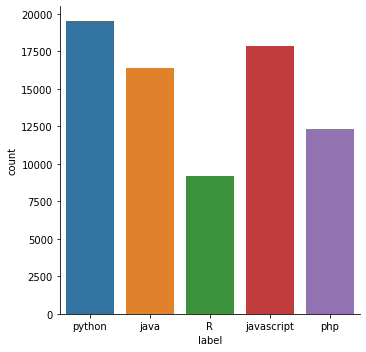

In [50]:
import seaborn as sns
sns.catplot(x="label",kind="count",data=data)

In [51]:
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
text = data['title']
def preprocessor(review):
  review=re.sub('<[^>]*>', '', review)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',review)
  review = (re.sub('[\W]+', ' ', review.lower()) +' '.join(emoticons).replace('-', ''))
  review = review.split()
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review if word not in stopwords.words("english")]
  review = " ".join(review)
  return review
text = text.apply(preprocessor)

Word2Vec

In [53]:
import gensim
sent = ([row.split() for row in text])
w2v = gensim.models.Word2Vec(sent,size=300,min_count=1,iter=10)

In [54]:
import numpy as np
embedding_matrix = np.zeros((len(w2v.wv.vocab) + 1, 300))
for i, vec in enumerate(w2v.wv.vectors):
  embedding_matrix[i] = vec

 Tfidf

In [55]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tf = CountVectorizer(min_df = 5,max_df = 0.8,max_features=3000)
X_tf = tf.fit_transform(text)

Tokenizer

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=len(w2v.wv.vocab)+1)
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22340 unique tokens.


In [57]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (75334, 31)


Train_test_split

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,random_state=0) 

In [59]:
X_train_tf, X_test_tf,Y_train_tf,Y_test_tf = train_test_split(X_tf,data['label'],train_size=0.8,random_state=0) 

#2 : Huấn luyện mô hình

LSTM

In [82]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
model = keras.Sequential()
model.add(layers.Embedding(len(w2v.wv.vocab)+1,300,input_length=X.shape[1],weights=[embedding_matrix]))
model.add(layers.LSTM(300))
model.add(layers.Dense(Y.shape[1],activation="softmax"))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 31, 300)           7142700   
_________________________________________________________________
lstm_9 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 1505      
Total params: 7,865,405
Trainable params: 7,865,405
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
for i in range(5) : 
  model.fit(X_train,Y_train,batch_size = 64 ,epochs=1,verbose=0)
  print("LSTM accuracy : ",model.evaluate(X_test,Y_test))

SVM


In [63]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear')
classifier.fit(X_train_tf,Y_train_tf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#3 : Đánh giá mô hình

In [64]:
print("LSTM accuracy : ",model.evaluate(X_test,Y_test))

471/471 [==============================] - 4s 9ms/step - loss: 0.5366 - accuracy: 0.8258
LSTM accuracy :  [0.536639392375946, 0.8258445858955383]


In [65]:
print("SVM accuracy : ",classifier.score(X_test_tf,Y_test_tf))

SVM accuracy :  0.7803809650228978


#4 : Lưu mô hình

In [66]:
import joblib
joblib.dump(classifier,'SVM.h5')
model.save('LSTM.h5')